# Lambda School Data Science Module 142
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [2]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 1], [2, 2]]).T
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [3]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=36.216308225555764, pvalue=1.3668743421581972e-08)


In [4]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## Live Lecture - let's explore some more of scipy.stats

In [0]:
# Taking requests! Come to lecture with a topic or problem and we'll try it.

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):

1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.

In [0]:
import pandas as pd
import numpy as np
import scipy

In [7]:
#http://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
!unzip drugsCom_raw.zip
df = pd.read_table('drugsComTrain_raw.tsv')
df.head()

--2018-12-05 15:56:22--  http://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42989872 (41M) [application/zip]
Saving to: ‘drugsCom_raw.zip’

drugsCom_raw.zip    100%[===================>]  41.00M  12.4MB/s    in 4.7s    

2018-12-05 15:56:26 (8.79 MB/s) - ‘drugsCom_raw.zip’ saved [42989872/42989872]

Archive:  drugsCom_raw.zip
  inflating: drugsComTest_raw.tsv    
  inflating: drugsComTrain_raw.tsv   


,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [8]:
df.pivot_table(index='drugName',values='rating', aggfunc='mean')

,rating
drugName,
A + D Cracked Skin Relief,10.000000
A / B Otic,10.000000
Abacavir / dolutegravir / lamivudine,8.211538
Abacavir / lamivudine / zidovudine,9.000000
Abatacept,7.157895
Abilify,6.540359
Abilify Discmelt,8.000000
Abilify Maintena,7.750000
Abiraterone,9.111111


In [0]:
drug_count_all = df.drugName.value_counts()
drug_count_all = drug_count_all[0:797]


In [10]:
print(drug_count_all)

Levonorgestrel                        3657
Etonogestrel                          3336
Ethinyl estradiol / norethindrone     2850
Nexplanon                             2156
Ethinyl estradiol / norgestimate      2117
Ethinyl estradiol / levonorgestrel    1888
Phentermine                           1543
Sertraline                            1360
Escitalopram                          1292
Mirena                                1242
Implanon                              1102
Gabapentin                            1047
Bupropion                             1022
Venlafaxine                           1016
Miconazole                            1000
Citalopram                             995
Medroxyprogesterone                    995
Lexapro                                952
Bupropion / naltrexone                 950
Duloxetine                             934
Metronidazole                          922
Contrave                               920
Drospirenone / ethinyl estradiol       890
Depo-Prover

In [11]:

unique_drugs_min_sample = []
unique_drugs_min_sample_frequency = []

for drugname, count in drug_count_all.items():
  x = drugname
  y = count
  
  print(x)
  print(y)
  unique_drugs_min_sample.append(x)
  unique_drugs_min_sample_frequency.append(y)




Levonorgestrel
3657
Etonogestrel
3336
Ethinyl estradiol / norethindrone
2850
Nexplanon
2156
Ethinyl estradiol / norgestimate
2117
Ethinyl estradiol / levonorgestrel
1888
Phentermine
1543
Sertraline
1360
Escitalopram
1292
Mirena
1242
Implanon
1102
Gabapentin
1047
Bupropion
1022
Venlafaxine
1016
Miconazole
1000
Citalopram
995
Medroxyprogesterone
995
Lexapro
952
Bupropion / naltrexone
950
Duloxetine
934
Metronidazole
922
Contrave
920
Drospirenone / ethinyl estradiol
890
Depo-Provera
882
Cymbalta
864
Clonazepam
831
Quetiapine
831
Skyla
824
Tramadol
820
Zoloft
805
Varenicline
794
Fluoxetine
766
Liraglutide
755
Tioconazole
706
Alprazolam
703
Amitriptyline
695
Lo Loestrin Fe
680
Paroxetine
645
Chantix
637
Ethinyl estradiol / etonogestrel
635
Pregabalin
632
Doxycycline
627
Magnesium sulfate / potassium sulfate / sodium sulfate
626
NuvaRing
622
Copper
608
Topiramate
606
Plan B
606
Suprep Bowel Prep Kit
598
Lamotrigine
591
Trazodone
584
Desvenlafaxine
582
Lorcaserin
572
Belviq
563
Pristiq
548
Az

In [0]:
#unique_drugs_min_sample
#unique_drugs_min_sample_frequency 

drug_pivot_rating_mean = df.pivot_table(index='drugName',values='rating', aggfunc='mean')

drug_pivot_df = pd.DataFrame(drug_pivot_rating_mean.to_records())

min_sample_mean_ratings = drug_pivot_df[drug_pivot_df.drugName.isin(unique_drugs_min_sample)]

In [13]:
min_sample_mean_ratings

,drugName,rating
2,Abacavir / dolutegravir / lamivudine,8.211538
5,Abilify,6.540359
11,Abreva,5.727848
14,Acamprosate,8.899083
15,Acanya,7.422222
19,Accutane,8.427273
21,Acetaminophen,8.033333
23,Acetaminophen / aspirin / caffeine,7.643678
26,Acetaminophen / butalbital / caffeine,8.899225
35,Acetaminophen / codeine,5.252427


In [0]:
pd.options.mode.chained_assignment = None
min_sample_mean_ratings['frequency'] = unique_drugs_min_sample_frequency


In [15]:
from scipy import stats
import math

stats = df.groupby(['drugName'])['rating'].agg(['mean', 'count', 'std'])
print(stats)
print('-'*30)


ci95_hi = []
ci95_lo = []


for i in stats.index:
  m, c, s = stats.loc[i]
  ci95_hi.append(m + 1.96*s/math.sqrt(c))
  ci95_lo.append(m - 1.96*s/math.sqrt(c))

  
stats['ci95_hi'] = ci95_hi
stats['ci95_lo'] = ci95_lo
print(stats)


                                                        mean  count       std
drugName                                                                     
A + D Cracked Skin Relief                          10.000000      1       NaN
A / B Otic                                         10.000000      1       NaN
Abacavir / dolutegravir / lamivudine                8.211538     52  2.491842
Abacavir / lamivudine / zidovudine                  9.000000      1       NaN
Abatacept                                           7.157895     19  3.419928
Abilify                                             6.540359    446  3.398206
Abilify Discmelt                                    8.000000      2  0.000000
Abilify Maintena                                    7.750000      4  4.500000
Abiraterone                                         9.111111      9  1.964971
AbobotulinumtoxinA                                  7.000000      3  1.732051
Abraxane                                            7.500000    

In [0]:
stats= stats.dropna()


In [0]:
sorted_stats = stats.sort_values('count', ascending=False)

In [18]:
top_twenty = sorted_stats.head(20)
top_twenty

,mean,count,std,ci95_hi,ci95_lo
drugName,,,,,
Levonorgestrel,7.391031,3657,3.130234,7.492485,7.289577
Etonogestrel,5.802458,3336,3.316617,5.915006,5.689910
Ethinyl estradiol / norethindrone,5.591930,2850,3.406496,5.716996,5.466863
Nexplanon,5.673006,2156,3.329435,5.813546,5.532465
Ethinyl estradiol / norgestimate,5.856873,2117,3.287545,5.996918,5.716828
Ethinyl estradiol / levonorgestrel,5.799258,1888,3.283538,5.947373,5.651144
Phentermine,8.786131,1543,1.977405,8.884797,8.687465
Sertraline,7.497794,1360,2.869493,7.650302,7.345286
Escitalopram,7.843653,1292,2.688936,7.990277,7.697029


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

!pip install seaborn --upgrade





    100% |████████████████████████████████| 215kB 25.0MB/s 
  Found existing installation: seaborn 0.7.1
    Uninstalling seaborn-0.7.1:
      Successfully uninstalled seaborn-0.7.1


In [0]:
top_twenty_mod = top_twenty.drop(['count', 'std'], axis = 1)
top_twenty_mod = top_twenty_mod[['ci95_hi', 'mean', 'ci95_lo']]

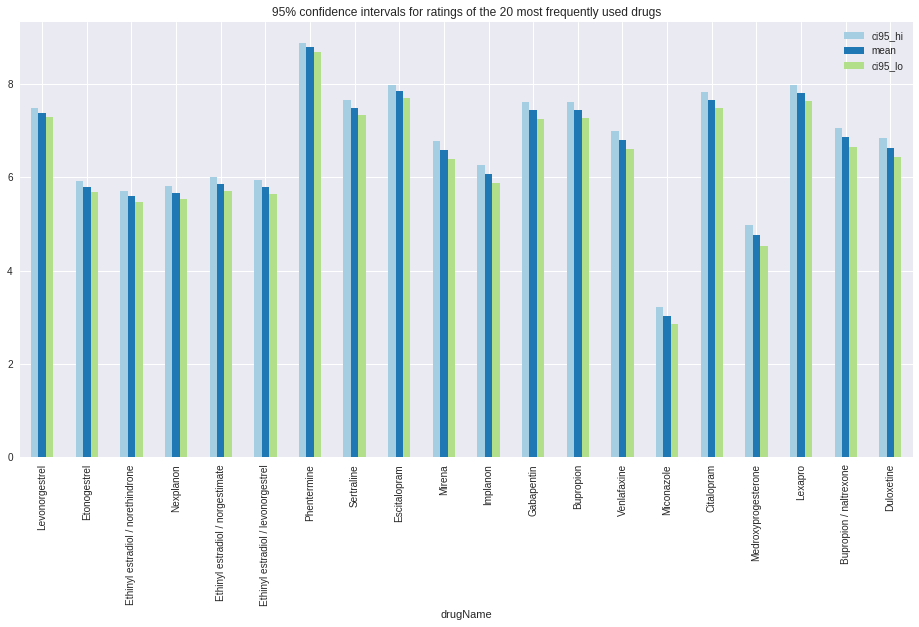

In [21]:
top_twenty_mod.plot(kind='bar', stacked=False,
              colormap=ListedColormap(sns.color_palette("Paired", 3)),
              title = '95% confidence intervals for ratings of the 20 most frequently used drugs',
              figsize=(16,8));